# Example how to use static STAC catalgoues with xarray and dask or rasterio

This example shows how tu use static [STAC](https://stacspec.org/en/about/) (Spatio-Temporal Asset Catalog) , [xarray](https://docs.xarray.dev/en/stable/) and [Dask](https://www.dask.org/) for processing big raster datasets, also with good support for time series. As extra, it is also shown how to find data URLs from STAC and use them with `Rasterio`. The main idea is to first find the data from STAC catalogue and then define processing as process graph in Dask. The downloading and processing is done lazily at the end, so that only needed data (only needed bands and area) is downloaded. The libraries take care of data download, so you do not need to know about file paths. These tools work best when data is provided as [Cloud-optimized GeoTiffs](https://www.cogeo.org/) (COGs).

For trying out this example, it is recommended to start interactive [Jupyter session](https://docs.csc.fi/computing/webinterface/jupyter/) with [Puhti web interface](https://docs.csc.fi/computing/webinterface/), for example with 2 cores and 12 Gb memory.

Dask is used for parallization of computing, see [CSC Dask tutorial](https://docs.csc.fi/support/tutorials/dask-python/), inc how to use Dask with Jupyter in
Puhti web interface and how to create batch jobs with Dask.

We'll search for Sentinel-2 data overlapping cetnral Helsinki. 

The main steps:
* Start Dask cluster
* Read STAC catalogue to copy metadata of all Sentinel2 L2A decade mosaic to memory.
* Create datacube of images from area of interest and required bands.
* Calculate timeseries for a point.
* Filter images only from 2020 summer.
* Finally, plot the single decade mosaic images.
* Close Dask cluster
* As extra, it is also shown how to find data URLs from STAC and use them with `Rasterio`.

In this example [FMI Tuulituhohaukka STAC catalogue](https://pta.data.lit.fmi.fi/stac/catalog.json) `Sentinel-2_global_mosaic_dekadi"` collection is used, but there are several [other STAC catalogues available](https://stacspec.org/en/about/datasets/). FMI data is stored in Sodankylä, Finland and is openly available without registration.

This example works with [geoconda module](https://docs.csc.fi/apps/geoconda/) in Puhti, the required libraries can be seen from imports.

The example is partly based on [Stackstac documentation](https://stackstac.readthedocs.io/en/latest/basic.html) and [Organizing Geospatial data with Spatio Temporal Assets Catalogs — STAC using python](https://towardsdatascience.com/organizing-geospatial-data-with-spatio-temporal-assets-catalogs-stac-using-python-45f1a64ca082).

In [1]:
from dask.distributed import Client
import numpy as np
from pystac import Catalog, Collection
import pystac_client
import stackstac

Start Dask cluster. 

For following how Dask works open [Dask Dashboard or JupyterLab Dask Extension](https://docs.csc.fi/support/tutorials/dask-python/#dask-with-jupyter).

In [3]:
client = Client()
client

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38678 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38678/status,
Dashboard: http://127.0.0.1:38678/status,Workers: 2
Total threads: 2,Total memory: 12.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33856,Workers: 2
Dashboard: http://127.0.0.1:38678/status,Total threads: 2
Started: Just now,Total memory: 12.00 GiB
Comm: tcp://127.0.0.1:45362,Total threads: 1
Dashboard: http://127.0.0.1:46272/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:35242,


## Read static catalogues with `pystac_client`

**This currently does not work with FMI STAC catalogue, because of minor problems in the syntax on FMI side. This should work with valid STAC catalogues.** If in hurry, jump to `Read static catalogues with PyStac`.

Open static catalog and read its general info.

In [4]:
URL = "https://pta.data.lit.fmi.fi/stac/catalog.json"
catalog = pystac_client.Client.open(URL)
print(f"ID: {catalog.id}")
print(f"Title: {catalog.title or 'N/A'}")
print(f"Description: {catalog.description or 'N/A'}")
print(f"Description: {catalog.links or 'N/A'}")

ID: root
Title: N/A
Description: Tuulituhohaukka catalog root
Description: [<Link rel=root target=<Client id=root>>, <Link rel=self target=https://pta.data.lit.fmi.fi/stac/catalog.json>, <Link rel=child target=https://pta.data.lit.fmi.fi/stac/catalog/Tuulituhoriski/Tuulituhoriski.json>, <Link rel=child target=https://pta.data.lit.fmi.fi/stac/catalog/MML-DTM-2m/MML-DTM-2m.json>, <Link rel=child target=https://pta.data.lit.fmi.fi/stac/catalog/Landsat_indeksit/Landsat_indeksit.json>, <Link rel=child target=https://pta.data.lit.fmi.fi/stac/catalog/Landsat_pintaheijastus/Landsat_pintaheijastus.json>, <Link rel=child target=https://pta.data.lit.fmi.fi/stac/catalog/Latvuskorkeusmalli/Latvuskorkeusmalli.json>, <Link rel=child target=https://pta.data.lit.fmi.fi/stac/catalog/Metsavarateema/Metsavarateema.json>, <Link rel=child target=https://pta.data.lit.fmi.fi/stac/catalog/Myrskytuhoriskikartta/Myrskytuhoriskikartta.json>, <Link rel=child target=https://pta.data.lit.fmi.fi/stac/catalog/Sentinel

Which collections the catalogue includes? This does not currently work with FMI.

In [12]:
# collections = list(catalog.get_collections())

# print(f"Number of collections: {len(collections)}")
# print("Collections IDs:")
# for collection in collections:
#     print(f"- {collection.id}")

Select one collection, from FMI currently only `Tuulituhoriski` collection works.

In [5]:
collection = catalog.get_collection('Tuulituhoriski')
collection

<CollectionClient id=Tuulituhoriski>

## Read static catalogues with `PyStac`

If you already know the link to collection .json page or to avoid FMI problems with collections listing it is possible to open Collection directly with PyStac library. Look for other FMI links here: https://pta.data.lit.fmi.fi/stac/catalog.json

In [6]:
collection = Collection.from_file('https://pta.data.lit.fmi.fi/stac/catalog/Sentinel-2_global_mosaic_dekadi/Sentinel-2_global_mosaic_dekadi.json')
# collection = Collection.from_file('https://pta.data.lit.fmi.fi/stac/catalog/Sentinel-1_dekadi_mosaiikki/Sentinel-1_dekadi_mosaiikki.json')
# collection = Collection.from_file('https://pta.data.lit.fmi.fi/stac/catalog/Tuulituhoriski/Tuulituhoriski.json')
# collection = Collection.from_file('https://pta.data.lit.fmi.fi/stac/catalog/Metsavarateema/Metsavarateema.json')

Get a list of all items (images) in the collection.

Depending on the collection size this step might take some time (even minutes) and for really big collections this is unfeasible.

In [7]:
items = list(collection.get_all_items())

See how many items were found and some basic info about the first item.

In [8]:
print(f"Number of items: {len(items)}")

for i, item in enumerate(items[:1]):
    print(f"{i}: {item}", flush=True)
    print(f"{i}: {item.bbox}", flush=True)
    print(f"{i}: {item.properties}", flush=True)
    print(f"{i}: {item.assets}", flush=True)

Number of items: 184
0: <Item id=Sentinel-2_global_mosaic_dekadi_2017-02-01_2017-02-10>
0: [15.201371090979, 59.1420203584345, 36.0214759928302, 70.0770184416577]
0: {'datetime': None, 'start_datetime': '2017-02-01T00:00:00Z', 'end_datetime': '2017-02-10T23:59:59Z'}
0: {'b01': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b01/s2m_sdr_20170201-20170210_b01_r20m.tif>, 'b02': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b02/s2m_sdr_20170201-20170210_b02_r20m.tif>, 'b03': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b03/s2m_sdr_20170201-20170210_b03_r20m.tif>, 'b04': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b04/s2m_sdr_20170201-20170210_b04_r20m.tif>, 'b05': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b05/s2m_sdr_20170201-20170210_b05_r20m.tif>, 'b06': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b06/s2m_sdr_20170201-20170210_b06_r20m.tif>, 'b07': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b07/s2m_sdr_20170201-20170210_b07_r20m.tif>, 'b08': <Asset href=htt

From this can be seen that:
* This specific collection includes 184 items at the time of writing this guideline, but it is regularly updated, so the number will increase.
* Each item has several assets with different Sentinel2 band values, but also different additional values from origional data and mosaicking.

To create the `xarray` DataSet we need to provide dataset's coordinate system and pixel size manually, because it is not provided by FMI in understandable way for stackstac.

To find out these see `gdalinfo` for one of the bands we will use.

In [9]:
!gdalinfo /vsicurl/https://pta.data.lit.fmi.fi/sen2/s2m_b04/s2m_sdr_20170201-20170210_b04_r20m.tif

Driver: GTiff/GeoTIFF
Files: /vsicurl/https://pta.data.lit.fmi.fi/sen2/s2m_b04/s2m_sdr_20170201-20170210_b04_r20m.tif
Size is 39590, 60869
Coordinate System is:
PROJCRS["ETRS89 / TM35FIN(E,N)",
    BASEGEOGCRS["ETRS89",
        ENSEMBLE["European Terrestrial Reference System 1989 ensemble",
            MEMBER["European Terrestrial Reference Frame 1989"],
            MEMBER["European Terrestrial Reference Frame 1990"],
            MEMBER["European Terrestrial Reference Frame 1991"],
            MEMBER["European Terrestrial Reference Frame 1992"],
            MEMBER["European Terrestrial Reference Frame 1993"],
            MEMBER["European Terrestrial Reference Frame 1994"],
            MEMBER["European Terrestrial Reference Frame 1996"],
            MEMBER["European Terrestrial Reference Frame 1997"],
            MEMBER["European Terrestrial Reference Frame 2000"],
            MEMBER["European Terrestrial Reference Frame 2005"],
            MEMBER["European Terrestrial Reference Frame 2

The `gdalinfo` output shows, that the data is in EPSG:3067 (Finnish TM35FIN) coordinate system and pixel size is 20 meters.

Next let's create the Xarray Dataset from all found items, but limiting the area of interest (=central Helsinki) and selecting only bands 2 to 4. The band names can be seen from the Item metadata printout above.

In [10]:
cube = stackstac.stack(
    items=[item.to_dict() for item in items],    # it needs the items as dictionaries items[:4]
    assets=['b04', 'b03', 'b02'],
    epsg=3067,
    resolution=20,
    bounds=(385480, 6671940, 387480, 6673940),
    xy_coords='center'
).squeeze()
cube

,Array,Chunk
Bytes,41.43 MiB,78.12 kiB
Shape,"(181, 3, 100, 100)","(1, 1, 100, 100)"
Count,1629 Tasks,543 Chunks
Type,float64,numpy.ndarray


Unfortunatelly also time info is not automatically created correctly, see NaT on the `time` row above.

The dates are correctly given under `start_datetime` and `end_datetime`, we will use `start_datetime` below as replacement for `time`. Because `start_datetime` was not read in proper datatime format, we need also convert it from string to `datatime64` type.

In [12]:
cube2 = cube.assign_coords(time=np.array(cube.start_datetime.values,dtype=np.datetime64))
cube2

/run/nvme/job_12715020/tmp/ipykernel_222798/830396749.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  cube2 = cube.assign_coords(time=np.array(cube.start_datetime.values,dtype=np.datetime64))


,Array,Chunk
Bytes,41.43 MiB,78.12 kiB
Shape,"(181, 3, 100, 100)","(1, 1, 100, 100)"
Count,1629 Tasks,543 Chunks
Type,float64,numpy.ndarray


Next well will plot a timeseries for a single pixel for 2017-(2022).
But first to avoid problems with a specific broken file, remove mosaic for 2020-01-21-2020-01-31.

In [13]:
cube3 = cube2[cube2.id!='Sentinel-2_global_mosaic_dekadi_2020-01-21_2020-01-31']
cube3

,Array,Chunk
Bytes,41.20 MiB,78.12 kiB
Shape,"(180, 3, 100, 100)","(1, 1, 100, 100)"
Count,2169 Tasks,540 Chunks
Type,float64,numpy.ndarray


Select data for one pixel for full timeseries.

In [14]:
b02_timeserires = cube3.sel(x=386600.0, y=6672680.0, band='b02')
b02_timeserires

<xarray.DataArray 'stackstac-943a3c717442e25b7d024bc5bf92c735' (time: 180)>
dask.array<getitem, shape=(180,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2017-02-01 2017-02-11 ... 2022-05-11
    id              (time) <U53 'Sentinel-2_global_mosaic_dekadi_2017-02-01_2...
    band            <U3 'b02'
    x               float64 3.866e+05
    y               float64 6.673e+06
    start_datetime  (time) <U20 '2017-02-01T00:00:00Z' ... '2022-05-11T00:00:...
    end_datetime    (time) <U20 '2017-02-10T23:59:59Z' ... '2022-05-20T23:59:...
    title           <U3 'b02'
    epsg            int64 3067
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(385480, 6671940, 387480, 66739...
    crs:         epsg:3067
    transform:   | 20.00, 0.00, 385480.00|\n| 0.00,-20.00, 6673940.00|\n| 0.0...
    resolution:  20

So far we have downloaded only metadata for the datacube, for next plot also actual data will be downloaded, but only as much as needed for the plot. It takes a moment to plot, please wait.

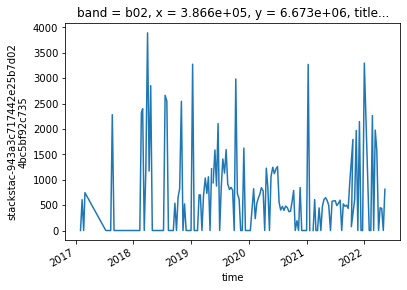

In [15]:
b02_timeserires.plot()

Finally, to print out some summer images from 2020 select the data for this period from datacube.

In [16]:
cube_2020 = cube3[cube3["time"] > np.datetime64('2020-05-31T00:00:00.000000000')]
cube_2020_summer = cube_2020[cube_2020["time"] < np.datetime64('2020-08-31T00:00:00.000000000')]
cube_2020_summer

<xarray.DataArray 'stackstac-943a3c717442e25b7d024bc5bf92c735' (time: 9,
                                                                band: 3,
                                                                y: 100, x: 100)>
dask.array<getitem, shape=(9, 3, 100, 100), dtype=float64, chunksize=(1, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2020-06-01 2020-06-11 ... 2020-08-21
    id              (time) <U53 'Sentinel-2_global_mosaic_dekadi_2020-06-01_2...
  * band            (band) <U3 'b04' 'b03' 'b02'
  * x               (x) float64 3.855e+05 3.855e+05 ... 3.874e+05 3.875e+05
  * y               (y) float64 6.674e+06 6.674e+06 ... 6.672e+06 6.672e+06
    start_datetime  (time) <U20 '2020-06-01T00:00:00Z' ... '2020-08-21T00:00:...
    end_datetime    (time) <U20 '2020-06-10T23:59:59Z' ... '2020-08-31T23:59:...
    title           (band) <U3 'b04' 'b03' 'b02'
    epsg            int64 3067
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(385480, 6671940, 387480, 66739...
    crs:         epsg:3067
    transform:   | 20.00, 0.00, 385480.00|\n| 0.00,-20.00, 6673940.00|\n| 0.0...
    resolution:  20

Plot the data for each decade.

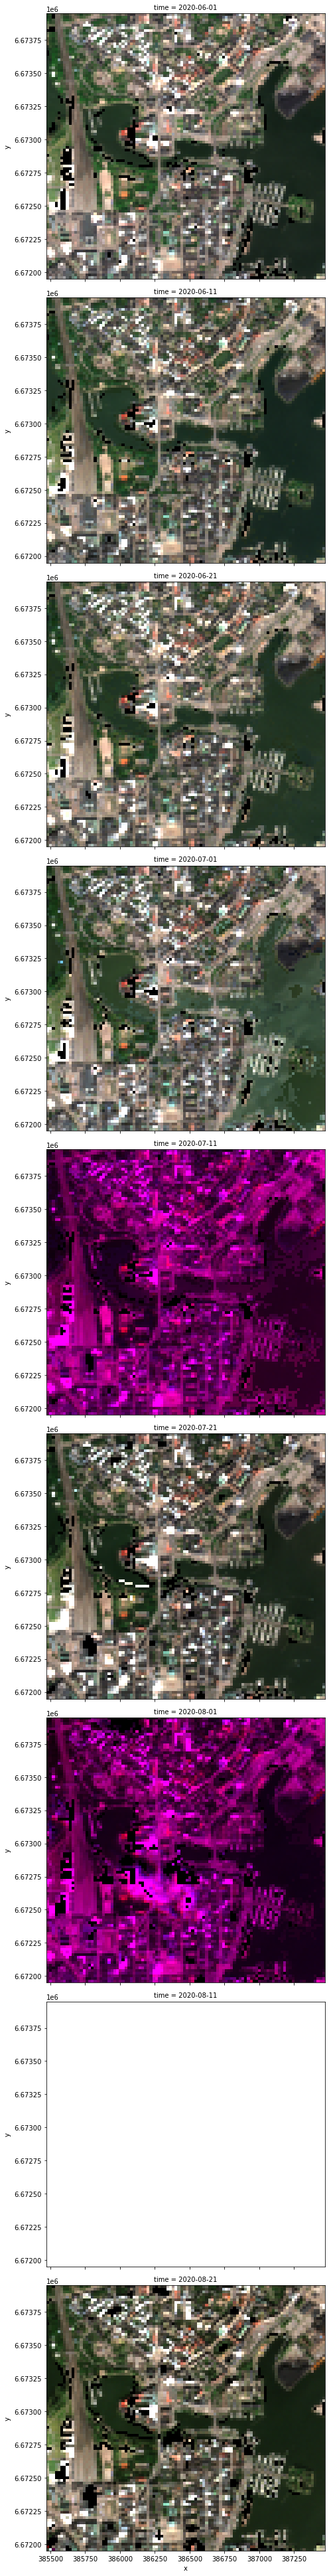

In [17]:
cube_2020_summer.plot.imshow(row="time", rgb="band", robust=True, size=6)

Some of the images do not look correct, let's check what is wrong.

In [18]:
cube_2020_summer[cube_2020_summer["time"]==np.datetime64('2020-08-21T00:00:00.000000000')].values #OK data

array([[[[1.740e+02, 2.250e+02, 0.000e+00, ..., 1.289e+03, 1.684e+03,
          1.322e+03],
         [1.650e+02, 1.970e+02, 4.920e+02, ..., 1.843e+03, 1.624e+03,
          1.438e+03],
         [2.510e+02, 2.380e+02, 3.950e+02, ..., 1.630e+03, 1.513e+03,
          1.301e+03],
         ...,
         [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.710e+02, 1.910e+02,
          3.980e+02],
         [7.410e+02, 0.000e+00, 9.310e+02, ..., 1.517e+03, 1.177e+03,
          1.262e+03],
         [4.860e+02, 1.611e+03, 6.080e+02, ..., 1.604e+03, 1.571e+03,
          1.507e+03]],

        [[2.950e+02, 3.560e+02, 0.000e+00, ..., 1.181e+03, 1.477e+03,
          1.222e+03],
         [2.760e+02, 3.570e+02, 5.090e+02, ..., 1.675e+03, 1.437e+03,
          1.297e+03],
         [4.360e+02, 3.660e+02, 4.800e+02, ..., 1.487e+03, 1.335e+03,
          1.172e+03],
         ...,
         [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.920e+02, 2.610e+02,
          5.000e+02],
         [1.000e+00, 0.000e+00, 8.300e+02, ..., 1.

In [19]:
cube_2020_summer[cube_2020_summer["time"]==np.datetime64('2020-08-11T00:00:00.000000000')].values #First band all 0, second all nan, third ok.

array([[[[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         ...,
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

        [[ 144.,  198.,  427., ...,  724., 1222., 1048.],
         [ 122.,  153.,  388., ..., 1377., 1327., 1207.],
         [ 147.,  162.,  290., ..., 1269., 1395., 1232.],
         ...,
         [   0.,    0.,  571., ...,  175.,  185.,  279.],
         [   0.,  525.,  8

In [20]:
cube_2020_summer[cube_2020_summer["time"]==np.datetime64('2020-08-01T00:00:00.000000000')].values #Second band all 0.

array([[[[ 161.,  208.,  685., ...,  985., 1584., 1181.],
         [ 111.,  171.,  521., ..., 1703., 1639., 1439.],
         [ 214.,  204.,  454., ..., 1860., 1541., 1326.],
         ...,
         [ 560.,  966.,  531., ...,  147.,  168.,  281.],
         [ 609.,  737.,  882., ...,  808.,  652., 1013.],
         [ 567., 1304., 1089., ..., 1822., 1447., 1449.]],

        [[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.]],

        [[ 152.,  103.,  551., ...,  866., 1304.,  913.],
         [  59.,  109.,  339., ..., 1454., 1343., 1234.],
         [ 194.,  194.,  295., ..., 1535., 1254., 1123.],
         ...,
         [ 538.,  825.,  507., ...,  178.,  205.,  304.],
         [ 543.,  609.,  7

If interested in working with other Python packages than 'xarray' or interested double-check the data problem, we can find from the items list created in the beginning of this Notebook, which files are related to specific date.

In [21]:
#Note this search is working with strings, not proper dates.
def search_items(items, date):
    for item in items:
        if item.properties["start_datetime"] == (date):
            return item

In [22]:
a = search_items(items, '2020-08-01T00:00:00Z')
a.assets

{'b01': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b01/s2m_sdr_20200801-20200810_b01_r20m.tif>,
 'b02': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b02/s2m_sdr_20200801-20200810_b02_r20m.tif>,
 'b03': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b03/s2m_sdr_20200801-20200810_b03_r20m.tif>,
 'b04': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b04/s2m_sdr_20200801-20200810_b04_r20m.tif>,
 'b05': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b05/s2m_sdr_20200801-20200810_b05_r20m.tif>,
 'b06': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b06/s2m_sdr_20200801-20200810_b06_r20m.tif>,
 'b07': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b07/s2m_sdr_20200801-20200810_b07_r20m.tif>,
 'b08': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b08/s2m_sdr_20200801-20200810_b08_r20m.tif>,
 'b8a': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b8a/s2m_sdr_20200801-20200810_b8a_r20m.tif>,
 'b11': <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_b11/s2m_sdr_20200801-2020

Then the files can be checked with `gdalinfo`, compared to command in the beginning, which fetched only saved metadata, the `-stats` flag enables calculating statistics for a file, but also downloads all data to local for a moment. So it takes a moment to finish.

In [23]:
!gdalinfo /vsicurl/https://pta.data.lit.fmi.fi/sen2/s2m_b03/s2m_sdr_20200801-20200810_b03_r20m.tif -stats

Driver: GTiff/GeoTIFF
Files: /vsicurl/https://pta.data.lit.fmi.fi/sen2/s2m_b03/s2m_sdr_20200801-20200810_b03_r20m.tif
Size is 39590, 60869
Coordinate System is:
PROJCRS["ETRS89 / TM35FIN(E,N)",
    BASEGEOGCRS["ETRS89",
        ENSEMBLE["European Terrestrial Reference System 1989 ensemble",
            MEMBER["European Terrestrial Reference Frame 1989"],
            MEMBER["European Terrestrial Reference Frame 1990"],
            MEMBER["European Terrestrial Reference Frame 1991"],
            MEMBER["European Terrestrial Reference Frame 1992"],
            MEMBER["European Terrestrial Reference Frame 1993"],
            MEMBER["European Terrestrial Reference Frame 1994"],
            MEMBER["European Terrestrial Reference Frame 1996"],
            MEMBER["European Terrestrial Reference Frame 1997"],
            MEMBER["European Terrestrial Reference Frame 2000"],
            MEMBER["European Terrestrial Reference Frame 2005"],
            MEMBER["European Terrestrial Reference Frame 2

The missing data seems to be related to Helsinki area only, because on file level the statistics look ok.

To plot the file and histogram in Helsinki area with rasterio,
but first close Dask cluster, because it is of now use with rasterio.

In [24]:
client.shutdown()

In [25]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds
from rasterio.plot import show
from rasterio.plot import show_hist

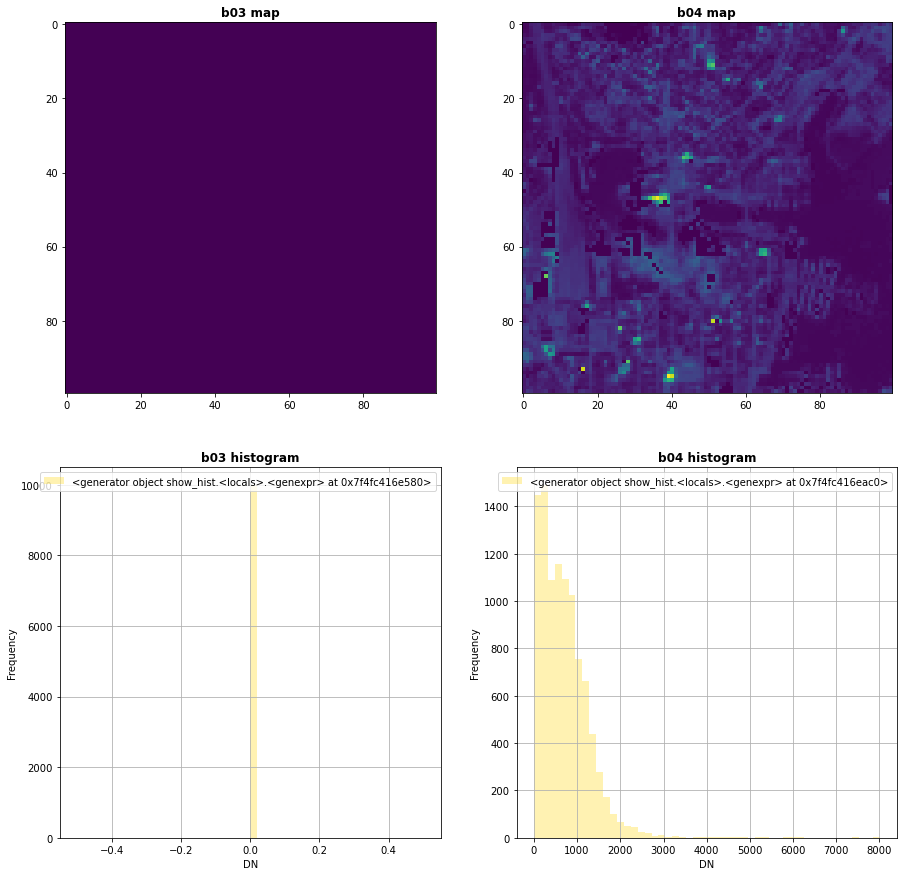

2022-08-11 15:03:01,600 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [26]:
filepath1='/vsicurl/https://pta.data.lit.fmi.fi/sen2/s2m_b03/s2m_sdr_20200801-20200810_b03_r20m.tif'
filepath2='/vsicurl/https://pta.data.lit.fmi.fi/sen2/s2m_b04/s2m_sdr_20200801-20200810_b04_r20m.tif'

### Create a subplot
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

# Add band3 map and histogram, not OK
with rasterio.open(filepath1) as src:
    rst = src.read(1, window=from_bounds(385480, 6671940, 387480, 6673940, src.transform))
    show(rst, ax=ax[0, 0], cmap='viridis', title='b03 map')
    show_hist(rst, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', ax=ax[1, 0], title="b03 histogram")
    
# Add band4 map and histogram, OK
with rasterio.open(filepath2) as src:
    rst = src.read(1, window=from_bounds(385480, 6671940, 387480, 6673940, src.transform))
    show(rst, ax=ax[0, 1], cmap='viridis', title='b04 map')
    show_hist(rst, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', ax=ax[1, 1], title="b04 histogram")    